In [1]:
from blimpy import Waterfall
import numpy as np
import matplotlib.pyplot as plt
import itertools, json
from astropy.stats.sigma_clipping import sigma_clip
from scipy.optimize import curve_fit
from scipy.interpolate import make_splrep
import scipy
from scipy import signal

In [2]:
"""
All these functions show the required modules imported within the function. This is simply to show as
clearly as possible which modules are required by each function. Of course, in general you should 
import all modules at the top of your script.
"""
from blimpy import Waterfall
import numpy as np
import matplotlib.pyplot as plt

def maxfreq(file):
    """Return central frequency of the highest-frequency bin in a .fil file.""" 
    
    fil = Waterfall(file)
    return fil.header['fch1']

def minfreq(file):
    """Return central frequency of the lowest-frequency bin in a .fil file"""
    
    fil = Waterfall(file)
    fch1 = fil.header['fch1']
    nchans = fil.header['nchans']
    ch_bandwidth = fil.header['foff']
    return fch1 + nchans*ch_bandwidth

def currentMJD():
    """Returns current MJD including decimals."""
    
    from astropy.time import Time
    print(Time.now().mjd) 

def AA(file): 
    """Returns Alt-Az coordinates (deg) for a given GBT .fil file.
    
    Args:
        file (str): .fil file
        
    Returns:
        altazdict (dict): Dictionary with alt and az in degrees.
    """
    
    from astropy import units as u
    from astropy.time import Time
    from astropy.coordinates import EarthLocation, SkyCoord, AltAz

    fil = Waterfall(file)
    
    GreenBank = EarthLocation(lat=38.4322*u.deg, lon=-79.8398*u.deg) #Western longitudes are negative
    MJD = fil.header['tstart']
    ra = fil.header['src_raj']
    dec = fil.header(file)['src_dej']
    target = SkyCoord(ra, dec)
    altaz = target.transform_to(AltAz(location=GreenBank, obstime=Time(MJD, format='mjd')))
    altazdict = { 'alt' : altaz.alt.degree, 'az' : altaz.az.degree }
    return altazdict

def totalpower(file, integration, fmin, fmax): 
    
    """Use Simpson's rule numerical integration to find total power between 
    given freq bounds, for given time integration.
    
    Args:
        file (str): .fil file
        integration (int): .fil file integration number to analyze
        fmin (float): Lower freq bound
        fmax (float): Upper freq bound
        
    Returns:
        totalpower (float): total power (from Simpson's rule)
                            under the power spectrum curve 
                            between fmin and fmax
    """
    
    import numpy as np
    from scipy.integrate import simps
    from blimpy import Waterfall
    
    #Get data
    fil = Waterfall(file)
    freqs = np.array(fil.freqs)
    data = np.array(fil.data[integration][0])
    
    #Check for valid bounds
    maxfreq = fil.header['fch1']
    nchans = fil.header['nchans']
    ch_bandwidth = read_header(file)['foff']
    minfreq = maxfreq + nchans*ch_bandwidth
    if fmin < minfreq or fmax > maxfreq:
        raise ValueError("One of your freq constraints is out of the freq range of this filterbank file.") 
    
    #Get freqs and power values from desired range
    idx = np.where(np.logical_and(freqs >= fmin, freqs <= fmax))
    newfreqs = freqs[idx]
    newdata = data[idx]
    
    #Integrate
    totalpower = simps(x=newfreqs, y=newdata)
    return totalpower

def freq2pix(freq,x):
    h = (x[-1]-x[0])/len(x)
    pix = int((freq - x[0])/h)
    return pix

In [3]:
def findline(p1, p2):
    #Returns the slope and intercept of line connecting two given points
    #p1 and p2 must be length-2 iterables containing the (x,y) coordinates
    x1, y1 = p1
    x2, y2 = p2
    m = (y2 - y1)/(x2 - x1) #slope
    b = y1 - m*x1 #intercept
    return m, b

def pad_data(x, y, n_pad = int(5)):
    #Pad data by simply extending a line in both directions with slope given by
    #the two points on each end of the data. n_pad is the no. of points to add on each side
    
    first_two_x = x[0:2]
    first_two_y = y[0:2]
    first_two_points = np.dstack([first_two_x, first_two_y])[0]
    left_m, left_b = findline(first_two_points[0], first_two_points[1]) #slope, intercept for left side

    last_two_x = x[-2:]
    last_two_y = y[-2:]
    last_two_points = np.dstack([last_two_x, last_two_y])[0]
    right_m, right_b = findline(last_two_points[0], last_two_points[1])

    pad_value = np.abs(x[n_pad] - x[0])
    left_pad_x = np.array(x[0:n_pad] - (pad_value))
    left_pad_y = left_m*left_pad_x + left_b
    right_pad_x = np.array(x[-n_pad:] + (pad_value))
    right_pad_y = right_m*right_pad_x + right_b

    padded_x = np.array(list(itertools.chain(left_pad_x, x, right_pad_x)))
    padded_y = np.array(list(itertools.chain(left_pad_y, y, right_pad_y)))

    return padded_x, padded_y

def CC_points(x, y):
    #Create a set of points from each coarse channel, to be used for plotting a spline.
    #x and y are 1-D iterables of equal length. Typically x will be the frequency array
    #and y the power array (of the entire spectrum). 
    x = np.array(x)
    y = np.array(y)
    num_CCs = int(len(x)/1024) #The number of coarse channels, since each one has length 1024
    
    #Make array of integers and split it into however many coarse channels there are
    coarsechans = np.split(np.arange(len(x)), num_CCs)

    yvals = []
    xvals = []
    for chan_idx in coarsechans:
        chanfreqs = x[chan_idx] #Frequencies for this coarse channel
        chanpowers = y[chan_idx] #Power values for this coarse channel
        
        power1 = np.percentile(chanpowers[0:255], 20)
        power2 = np.percentile(chanpowers, 10)
        power3 = np.percentile(chanpowers[-255:], 20)
        
        powers = [power1, power2, power3]
        freqs = np.percentile(chanfreqs, [10,50,90])
        
        for f in freqs:
            xvals.append(f)
        
        for p in powers:
            yvals.append(p)
    
    #To prevent spline from misbehaving at edges, pad with points                                               
    xvals, yvals = pad_data(xvals, yvals)
    return xvals, yvals


In [4]:
def clean_CC_points(xvals, yvals):
    #Now clean the representative points in each coarse channel, 
    #reject outliers and dragging down their positions                                                                                              
    for i in np.arange(10): #Do this same thing 5 times                                                                                          
        for i in np.arange(1, len(xvals)-1):
            previousp = np.array([xvals[i-1], yvals[i-1]]) #Point on the left
            currentp = np.array([xvals[i], yvals[i]]) #Current points in question
            nextp = np.array([xvals[i+1], yvals[i+1]]) #point on the right
            m, b = findline(previousp, nextp) #slope and intercept of a line connecting left and right points
            interpolatedp = np.array([xvals[i], m*xvals[i]+b]) #what the power level would be if on this line

            #If current actualy point is higher than both of the two on the sides, 
            #and the distance between it and the line connecting the two 
            #is sufficiently large, replace its y value. with the interpolated one
            if (currentp[1] > previousp[1] and currentp[1] > nextp[1]) and \
            currentp[1]-interpolatedp[1] > .01*np.linalg.norm(currentp - previousp) \
            and currentp[1] > interpolatedp[1]:
                #Replace current point with interpolation                                                       
                m, b = findline(previousp, nextp)
                yvals[i] = m*xvals[i]+b
    return xvals, yvals 

In [5]:
def trend_spline(x,y,k=3):
    #x is the frequency array, y is power. k is the order of the polynomials
    #used for the spline.
    initial_x, initial_y = CC_points(x, y)
    cleaned_x, cleaned_y = clean_CC_points(initial_x, initial_y)
    
    #Build spline                                                                                                                               
    N=len(x); rmserror=.00001
    #This just sets the tolerance for how close the spline must be to the given points. s is
    #a parameter that is related to how many nodes there are in the spline.
    spl = make_splrep(cleaned_x, cleaned_y, k=k)
    return cleaned_x, cleaned_y, spl

In [6]:
def clip(x, y, sigma_lower=5, sigma_upper=.1):
    clipped = sigma_clip(y, sigma_lower=sigma_lower, sigma_upper=sigma_upper) #Determined the 
    #thresholds by trial and error
    rejected = np.ma.getmask(clipped)
    idx_rejected = np.where(rejected)[0] #indices of clipped values
    clipped_data = np.delete(y, idx_rejected)
    clipped_freqs = np.delete(x, idx_rejected)
    return clipped_freqs, clipped_data, idx_rejected

In [7]:
def fourier_components(x, y, n):
    FFT = np.fft.fft(y)/len(y)
    amplitudes = np.abs(FFT)
    freqs = np.fft.fftfreq(len(y),x[1]-x[0])
    phases = np.array([np.arctan2(item.imag, item.real) for item in FFT])
    
    #take n freqs with largest amplitudes
    max_idx = amplitudes.argsort()[-n:]
    max_freq = freqs[max_idx]
    max_phase = phases[max_idx]
    max_amp = amplitudes[max_idx]
    
    #This creates a list of tuples. Each tuple contains the amplitude, frequency, and phase offset of a
    #single component, i.e. a single term in the series
    params = np.dstack([max_amp, max_freq, max_phase])[0] 
    
    series = np.zeros(len(x)) #Make an array of zeros to which we will add the values from each term
    for i in np.arange(len(max_idx)):
        series += np.array([params[i][0]*np.cos(2*np.pi*params[i][1]*(val) + params[i][2]) for val in x])
    plt.figure(1, figsize=(9,5))
    plt.scatter(x, y, s=6)
    plt.plot(x, series, color='yellow', linewidth=2); plt.tight_layout()
    return params

In [8]:
def fourier_fit(freqs, transformed_data):
    #transformed data is the logged, detrended, sigma clipped data.
    num_CCs = int(len(freqs)/1024) #number of coarse channels, since each one
    #is 1024 bins long
    coarsechans = np.split(np.arange(len(freqs)), num_CCs)

    #First find the coarse channel with smallest variance                                                                                                              
    chanvars = []
    for i in np.arange(len(coarsechans)):
        chan = coarsechans[i] #indices
        chanpowers = transformed_data[chan]
        chanvars.append(np.var(chanpowers))
        
    #Extract info for CC with smallest variance   
    quietest_chan_idx = chanvars.index(sorted(chanvars)[0])                                                     
    quietest_chan_powers = transformed_data[coarsechans[quietest_chan_idx]]
    quietest_chan_freqs = freqs[coarsechans[quietest_chan_idx]]
    
    fourier_tuples = fourier_components(quietest_chan_freqs, quietest_chan_powers, 35)
    
    
    #We don't want large values to impact the sum of squares and drag up the vertical offset. 
    #So first we sigma clip the data and we will feed the clipped version to the curve fit procedure.

    #This function is here purely for use by scipy.curve_fit
    def CC_fourier_fit(freqs_CC,D):
        #Fit one Fourier period to a quiet coarse channel, use this to determine phase and vertical shift.  
        #freqs_CC is the frequencies of this coarse channel
        fit = np.zeros(len(freqs_CC))
        for i in np.arange(len(fourier_tuples)): #Build Fourier series term-by-term
            fit += np.array([fourier_tuples[i][0]*np.cos(2*np.pi*fourier_tuples[i][1]*(val+D) +\
                                                                    fourier_tuples[i][2]) for val in freqs_CC])
        #fit += np.array([C]*len(freqs_CC)) #Add constant vertical shift
        return np.array(fit)

    print("Fitting to a coarse channel to find optimal phase and offset...")
    parameters = curve_fit(CC_fourier_fit, quietest_chan_freqs, quietest_chan_powers)[0]
    fourier_CC = CC_fourier_fit(quietest_chan_freqs, *parameters)

    print("The algorithm seems to failed on finding phase offset so adding one part to find better offset ...")
    correlation = signal.correlate(fourier_CC, quietest_chan_powers, mode="same")
    lags = signal.correlation_lags(fourier_CC.size, quietest_chan_powers.size, mode="same")
    lag = lags[np.argmax(correlation)] + 0.5
    print("Lag of the fit: ",lag)
    
    fourier_CC_shift = CC_fourier_fit(quietest_chan_freqs - lag, *parameters)
    
    print("Found phase and offset. Constructing full spectrum Fourier fit...")
    #Tile the single-channel fit to get the fit for the entire spectrum
    fourier_fit = np.tile(fourier_CC_shift, len(coarsechans))
    
    return fourier_fit

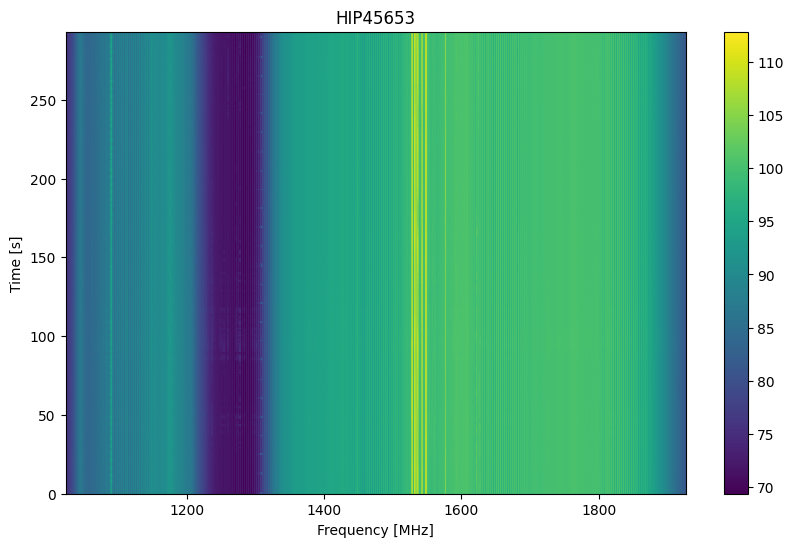

Fitting to a coarse channel to find optimal phase and offset...
The algorithm seems to failed on finding phase offset so adding one part to find better offset ...
Lag of the fit:  0.5
Found phase and offset. Constructing full spectrum Fourier fit...
Done fitting.



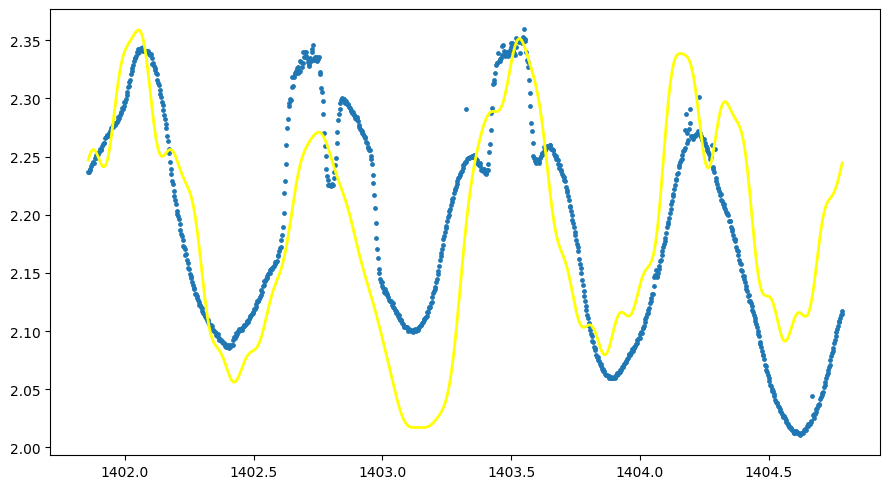

In [9]:
%matplotlib inline
def fit_file_0002(file, integration=None, plot=False):
    #If integration is not provided, sum the power over the time axis.
    #Otherwise just get the power values for the given integration.
    
    fil = Waterfall(file)

    plt.figure(figsize=(10,6))
    fil.plot_waterfall()
    plt.show()
    
    data = np.sum(fil.data, axis=0)[0]
    
    #Get frequencies
    freqs = fil.freqs
    
    #Log the data to equalize the heights of the troughs
    logged_data = np.log(data)

    #Flip the data if needed
    if freqs[0] > freqs[-1]:
        freqs = np.flip(freqs)
        data = np.flip(data)

    
    
    #Get spikes
    last_index = len(freqs)-1
    spikes = np.arange(511, last_index, 1024)
    
    #Get CC points, create spline fit, detrend, and clip
    xpoints, ypoints, spl = trend_spline(freqs, logged_data)
    detrended = logged_data - spl(freqs)
    clipped_freqs, clipped_data, idx_rejected = clip(freqs, detrended)
    
    fit = np.exp(fourier_fit(freqs, detrended) + spl(freqs))
    print("Done fitting." + '\n')

    if plot:
        plt.figure(figsize=(9,6))
        plt.scatter(freqs, data, s=4)
        plt.plot(freqs, fit, color='yellow', linewidth=1)
        plt.grid()
        plt.tight_layout()
        plt.show()

    return np.array(freqs), np.array(data), np.array(fit)

filename = 'spliced_blc0001020304050607_guppi_57571_78180_HIP45653_0042.gpuspec.0002.h5'
freqs, data, fit = fit_file_0002(filename)

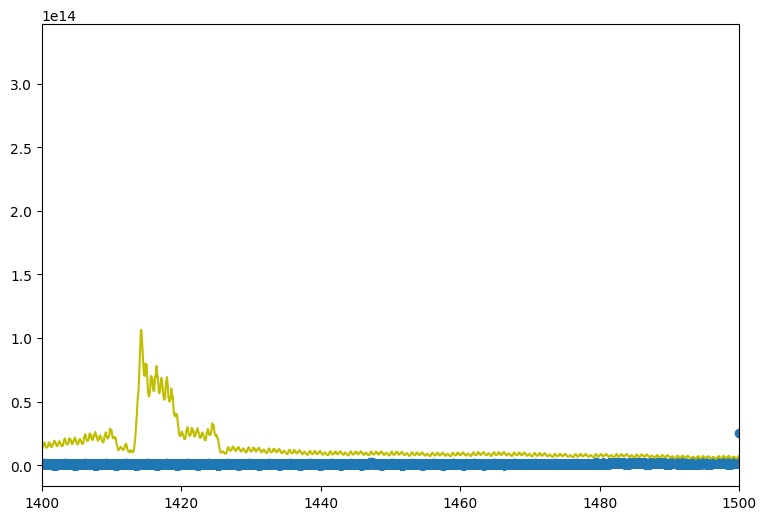

In [10]:
%matplotlib inline 
plt.figure(figsize = [9,6])
plt.scatter(freqs, data)
plt.plot(freqs, fit, 'y')
plt.xlim(1400,1500)
plt.show()